In [ ]:
# Analyse diff STAR HHV8 :
# install :

In [1]:
import os
import pandas as pd

count_dir = "./count_star"
output_matrix = "./count_star/gene_count_matrix_STAR.csv"

files = [f for f in os.listdir(count_dir) if f.endswith("_ReadsPerGene.out.tab")]
dfs = []

for file in files:
    sample_name = file.replace("_not_hg38_ReadsPerGene.out.tab", "")  
    path = os.path.join(count_dir, file)


    df = pd.read_csv(path, sep='\t', skiprows=1, header=None)


    if len(df.columns) < 2:
        logging.warning(f"Fichier {file} a seulement {len(df.columns)} colonnes → skip")
        continue

    # Geneid + dernier colonne = nmb de reads
    df.columns = ['Geneid'] + [f"col{i}" for i in range(1, len(df.columns))]
    df = df[['Geneid', df.columns[-1]]]
    df.columns = ['Geneid', sample_name]

    dfs.append(df.set_index('Geneid'))

combined_df = pd.concat(dfs, axis=1)

# rm les  "unassigned"
gene_mask = ~combined_df.index.str.contains("N_", na=True) & ~combined_df.index.str.contains("unassigned", na=True)
combined_df = combined_df[gene_mask]


combined_df.to_csv(output_matrix)
print(f"Matrice Done  : {output_matrix}")

Matrice Done  : ./count_star/gene_count_matrix_STAR.csv


In [2]:
#Charger les data et librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


matrix_path = "./count_star/gene_count_matrix_STAR.csv"
df_counts = pd.read_csv(matrix_path, index_col=0)

print("Dimensions:", df_counts.shape)
df_counts.head()

Dimensions: (18, 45)


,KAP_53_S11,KAP_74_S3,KAP_41_S2,KAP_40_S3,KAP_37_S1,KAP_65_2_S2,KAP38_S3,KAP_67_S5,KAP_42_1_S4,KAP_68_S9,...,KAPKEY21_S14,KAP_78_S7,KAP51_S5,KAP36_S2,KAP_72_S12,KAP32_S1,KAPKEY22_S15,KAP_45_S7,KAP_62_2_S1,KAP_56_S12
Geneid,,,,,,,,,,,,,,,,,,,,,
HHV8GK18_gp01,0,12,0,0,0,0,3,0,0,0,...,0,0,3,1,0,4,0,113,4,0
HHV8_gs01,0,0,0,0,12,0,2,0,0,0,...,0,0,407,24,0,13896,0,187,112,1
HHV8GK18_gp38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,12,0,0,2,0
HHV8GK18_gp39,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HHV8GK18_gp62,0,0,0,1,0,0,1,0,0,0,...,0,0,83,0,0,51,0,2,5,0


Statistiques par échantillon


,Total Reads,Moyenne par gène,Médiane par gène
KAP_62_2_S1,61449,3413.833333,93.5
KAP32_S1,48918,2717.666667,76.0
KAP_63_S5,27976,1554.222222,44.0
KAP_45_S7,22586,1254.777778,16.5
KAP51_S5,18866,1048.111111,76.0
KAP38_S3,9569,531.611111,19.0
KAP_33_S1,5894,327.444444,5.5
KAP_37_S2,3372,187.333333,3.0
KAP_64_S6,3026,168.111111,4.0
KAP39_S4,2114,117.444444,3.5


/tmp/ipykernel_214638/1838346039.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_reads_per_sample.index, y="Total Reads", data=total_reads_per_sample, palette="viridis")


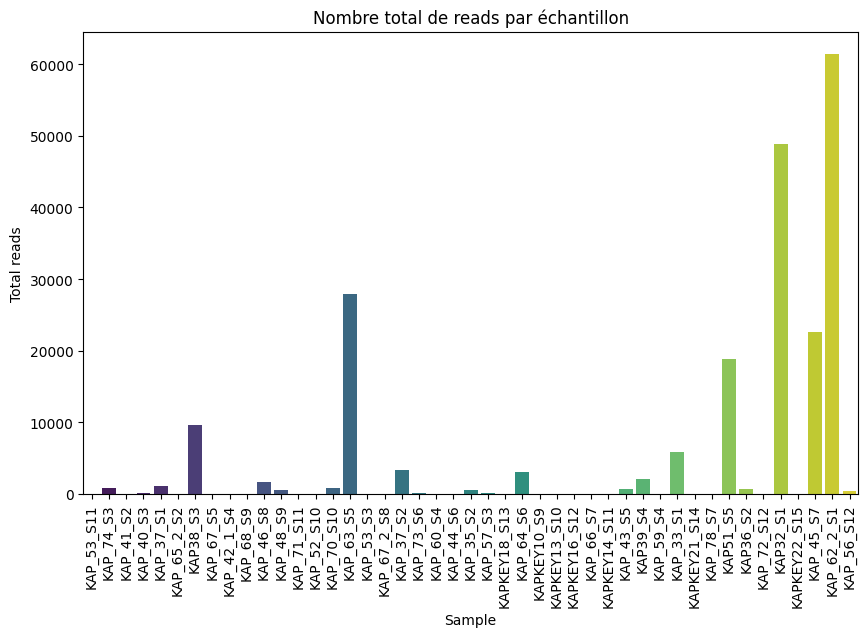

In [6]:
#Tableau : Nombre total de reads par échantillon + Graphique

# total de reads par sample
total_reads_per_sample = df_counts.sum().to_frame(name="Total Reads")
total_reads_per_sample["Moyenne par gène"] = df_counts.mean()
total_reads_per_sample["Médiane par gène"] = df_counts.median()

print("Statistiques par échantillon")
display(total_reads_per_sample.sort_values(by="Total Reads", ascending=False))

# Histogramme
plt.figure(figsize=(10,6))
sns.barplot(x=total_reads_per_sample.index, y="Total Reads", data=total_reads_per_sample, palette="viridis")
plt.xticks(rotation=90)
plt.title("Nombre total de reads par échantillon")
plt.xlabel("Sample")
plt.ylabel("Total reads")
plt.show()

🧮 Statistiques descriptives par échantillon


,mean,50%,std,min,max
KAP_53_S11,0.000000,0.0,0.000000,0.0,0.0
KAP_74_S3,47.166667,6.0,178.460821,0.0,762.0
KAP_41_S2,0.000000,0.0,0.000000,0.0,0.0
KAP_40_S3,8.722222,0.0,35.760322,0.0,152.0
KAP_37_S1,57.666667,1.0,236.193091,0.0,1004.0
KAP_65_2_S2,0.000000,0.0,0.000000,0.0,0.0
KAP38_S3,531.611111,19.0,2143.793014,0.0,9121.0
KAP_67_S5,0.000000,0.0,0.000000,0.0,0.0
KAP_42_1_S4,0.000000,0.0,0.000000,0.0,0.0
KAP_68_S9,0.000000,0.0,0.000000,0.0,0.0


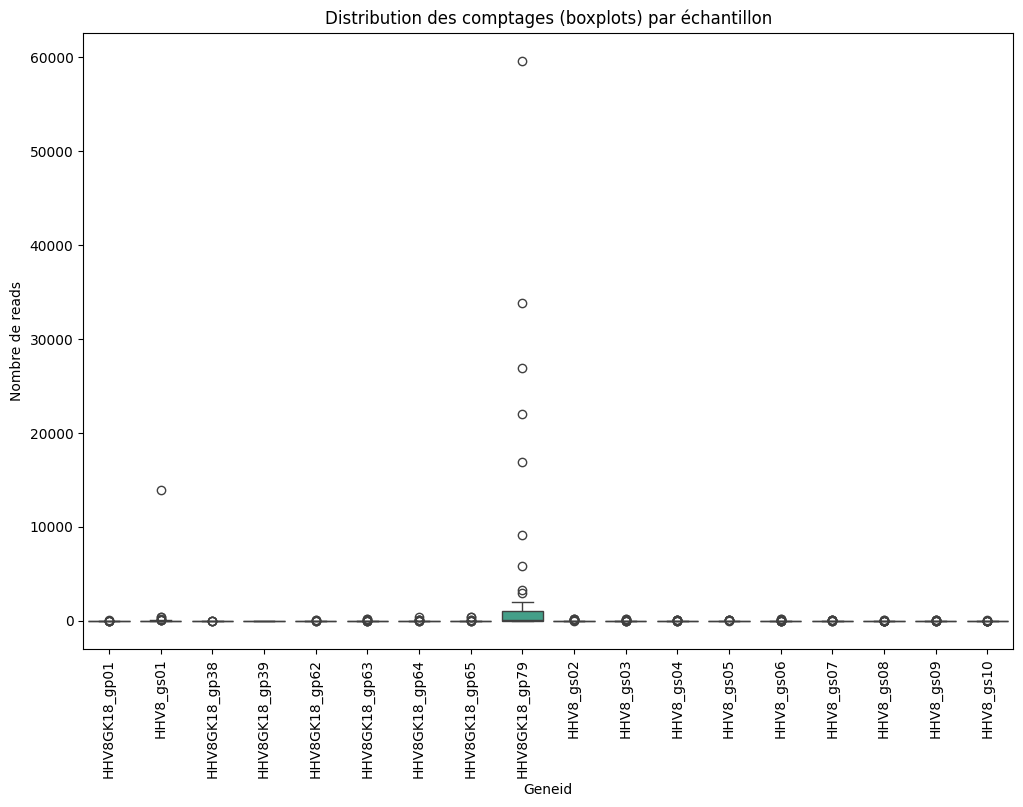

In [ ]:

# Tableau : Statistiques par échantillon + Boxplot
stats_df = df_counts.describe().T
stats_df = stats_df[['mean', '50%', 'std', 'min', 'max']]
print("Statistiques descriptives par échantillon")
display(stats_df)

# Graphique : Boxplot
plt.figure(figsize=(12,8))
sns.boxplot(data=df_counts.T)
plt.xticks(rotation=90)
plt.title("Distribution des comptages (boxplots) par échantillon")
plt.ylabel("Nombre de reads")
plt.show()

In [ ]:
# Dictionnaire : identifiant → abréviation/fonction
gene_abbr = {
    "HHV8GK18_gp01": "ORF1 (K1)",
    "HHV8_gs01": "ORF2",
    "HHV8GK18_gp39": "ORF39 (M7)",
    "HHV8GK18_gp62": "ORF62 (K8.1)",
    "HHV8GK18_gp63": "ORF63",
    "HHV8GK18_gp64": "ORF64",
    "HHV8GK18_gp65": "ORF65 (capsid)",
    "HHV8GK18_gp79": "ORF79",
    "HHV8_gs02": "ORF3",
    "HHV8_gs03": "ORF4",
    "HHV8_gs04": "ORF5",
    "HHV8_gs05": "ORF6",
    "HHV8_gs06": "ORF7",
    "HHV8_gs07": "ORF8",
    "HHV8_gs08": "ORF9",
    "HHV8_gs09": "ORF10",
    "HHV8_gs10": "ORF11"
}

# Exemple d'utilisation : obtenir l'abréviation d'un gène 
# K12 =  HHV8GK18_gp79 
gene_ids = df_counts.index  # Utilise l'index du DataFrame comme liste des gènes
for gene in gene_ids:
    print(f"{gene} : {gene_abbr.get(gene, 'NA')}")

HHV8GK18_gp01 : ORF1 (K1)
HHV8_gs01 : ORF2
HHV8GK18_gp38 : NA
HHV8GK18_gp39 : ORF39 (M7)
HHV8GK18_gp62 : ORF62 (K8.1)
HHV8GK18_gp63 : ORF63
HHV8GK18_gp64 : ORF64
HHV8GK18_gp65 : ORF65 (capsid)
HHV8GK18_gp79 : ORF79
HHV8_gs02 : ORF3
HHV8_gs03 : ORF4
HHV8_gs04 : ORF5
HHV8_gs05 : ORF6
HHV8_gs06 : ORF7
HHV8_gs07 : ORF8
HHV8_gs08 : ORF9
HHV8_gs09 : ORF10
HHV8_gs10 : ORF11


🧮 Corrélation entre échantillons (Pearson)


,KAP_53_S11,KAP_74_S3,KAP_41_S2,KAP_40_S3,KAP_37_S1,KAP_65_2_S2,KAP38_S3,KAP_67_S5,KAP_42_1_S4,KAP_68_S9,...,KAPKEY21_S14,KAP_78_S7,KAP51_S5,KAP36_S2,KAP_72_S12,KAP32_S1,KAPKEY22_S15,KAP_45_S7,KAP_62_2_S1,KAP_56_S12
KAP_53_S11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KAP_74_S3,NaN,1.000000,NaN,0.999649,0.999519,NaN,0.999663,NaN,NaN,NaN,...,-0.046382,0.999653,0.999330,0.998843,NaN,0.919403,0.693791,0.999643,0.999657,0.999593
KAP_41_S2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KAP_40_S3,NaN,0.999649,NaN,1.000000,0.999830,NaN,0.999847,NaN,NaN,NaN,...,-0.053892,0.999919,0.999588,0.999228,NaN,0.921540,0.684443,0.999872,0.999924,0.999669
KAP_37_S1,NaN,0.999519,NaN,0.999830,1.000000,NaN,0.999874,NaN,NaN,NaN,...,-0.060932,0.999918,0.999616,0.999630,NaN,0.926424,0.685168,0.999961,0.999929,0.999551
KAP_65_2_S2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KAP38_S3,NaN,0.999663,NaN,0.999847,0.999874,NaN,1.000000,NaN,NaN,NaN,...,-0.060723,0.999923,0.999355,0.999157,NaN,0.921261,0.685488,0.999860,0.999944,0.999534
KAP_67_S5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KAP_42_1_S4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KAP_68_S9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


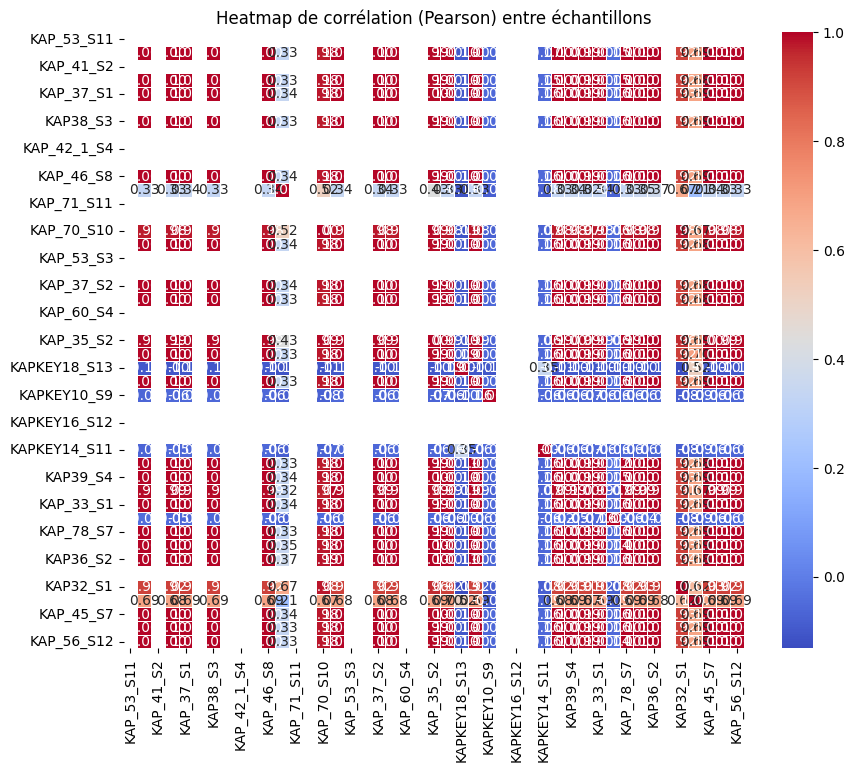

In [10]:
#Corrélation entre échantillons + Heatmap
corr_matrix = df_counts.corr(method="pearson")
print("🧮 Corrélation entre échantillons (Pearson)")
display(corr_matrix)

# Graphique : Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap de corrélation (Pearson) entre échantillons")
plt.show()

In [ ]:
# Coordonnées PCA + Graphique
# Normalisation standard
X_std = StandardScaler().fit_transform(df_counts)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_std)

# Création d’un dataframe
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index=df_counts.columns)
explained_variance = pca.explained_variance_ratio_

print(f"🧮 Coordonnées PCA (explicite {explained_variance[0]*100:.1f}% PC1, {explained_variance[1]*100:.1f}% PC2)")
display(pca_df)

# Graphique : PCA
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, s=100)
plt.title("PCA des échantillons")
for i, txt in enumerate(pca_df.index):
    plt.annotate(txt, (pca_df.iloc[i, 0], pca_df.iloc[i, 1]))
plt.grid(True)
plt.show()

In [ ]:
#Filtrage des gènes faiblement exprimés + Stats
# Filtrer les gènes exprimés dans au moins 2 échantillons avec > 10 reads
threshold = 10
min_samples = 2
mask = (df_counts > threshold).sum(axis=1) >= min_samples
filtered_df = df_counts[mask]

print(f"🧬 Gènes avant filtrage : {df_counts.shape[0]}")
print(f"🧬 Gènes après filtrage (>={min_samples} échantillons avec >{threshold} reads) : {filtered_df.shape[0]}")

# Exemple : Afficher quelques gènes filtrés
print("\n🧬 Exemples de gènes conservés :")
display(filtered_df.sample(5))